# Convolutions as Density Transformations

In [1]:
import itertools
import torch
import matplotlib.pyplot as plt
import math

import convnet_phi4.plot as plot

%load_ext lab_black

PI = math.pi

torch.set_printoptions(precision=3, sci_mode=False, threshold=4000)

''

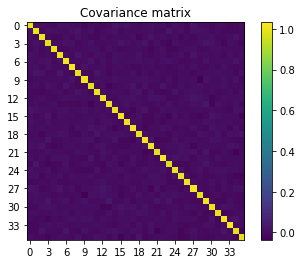

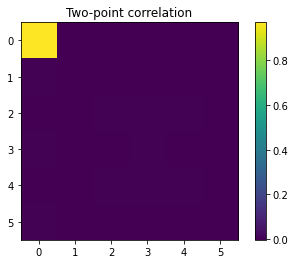

In [3]:
def conv2d_inputs(phi, w):
    """Reshape and pad inputs for conv2d.

    conv2d expects shapes:

    - input (phi) : (batch size, input channels, width, height)
    - kernel (w)  : (batch size, output channels, kernel width, kernel height)

    However, our input is periodic so we also need to pad phi by an amount
    K, which is the kernel radius.
    """
    assert phi.dim() in (2, 3)
    assert w.dim() == 2

    if phi.dim() == 2:
        phi = phi.unsqueeze(0)  # add batch dim
    phi = phi.unsqueeze(1)  # add channel dim

    k1, k2 = [(k - 1) // 2 for k in w.shape]
    w = w.view(1, 1, *w.shape)
    phi = torch.nn.functional.pad(
        phi,  # (n_batch, n_channels, width, height)
        pad=(k2, k2, k1, k1),  # pad last 2 dimensions by kernel radius on each side
        mode="circular",
    )
    return phi, w

def get_covariance(phi):
    assert phi.dim() == 3
    cov = torch.cov(phi.flatten(start_dim=1).T)
    assert cov.shape == torch.Size([phi.flatten(start_dim=1).shape[1]] * 2)

    L = phi.shape[1]

    cov_with_geometry = torch.stack(
        [
            row.view(L, L).roll((-(i // L), -(i % L)), dims=(0, 1))
            for i, row in enumerate(cov.split(1, dim=0))
        ],
        dim=0,
    ).mean(dim=0)

    return cov, cov_with_geometry

## Simple examples with diagonal Gaussian prior

It's useful to see how cross-correlating a diagonal Gaussian with different kernels results in different output covariances.

''

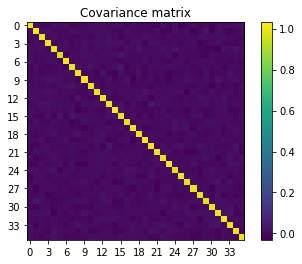

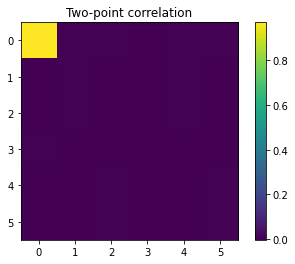

In [4]:
L = 6
prior = torch.distributions.Normal(loc=torch.zeros(L, L), scale=torch.ones(L, L))
phi = prior.sample([10000])

plot.heatmap_covariance(phi)
plot.heatmap_correlator(phi)
_

### Example: Nearest horizontal, positive neighbour

Now consider the kernel

$$
w = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 1/2 \\
0 & 0 & 0
\end{pmatrix}
$$

and the covariance of $(w \star \phi)_{00} = \phi_{00} + \frac{1}{2}\phi_{01}$, where $\langle \phi_x \rangle = 0$ for all $x$ and $\langle \phi_x \phi_y \rangle = \delta_{xy}$.

Firstly, the variance,

$$
\langle (w \star \phi)_{00} (w \star \phi)_{00} \rangle 
= \langle \phi_{00} \phi_{00} \rangle
+ \frac{1}{4} \langle \phi_{01}\phi_{01} \rangle 
= \frac{5}{4}
$$

Now the covariance with the (0, 1) element, $(w \star \phi)_{01} = \phi_{01} + \frac{1}{2}(\phi_{02} + \phi_{11})$,

$$
\langle (w \star \phi)_{00} (w \star \phi)_{01} \rangle 
= \frac{1}{2} \langle \phi_{01} \phi_{01} \rangle
= \frac{1}{2}
$$

By considering $(w \star \phi)_{0L}$, which picks up a contribution $\frac{1}{2} \phi_{00}$, we also find that $\langle (w \star \phi)_{00} (w \star \phi)_{0L} \rangle = \frac{1}{2}$.

''

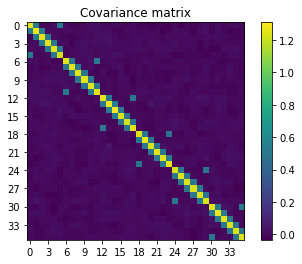

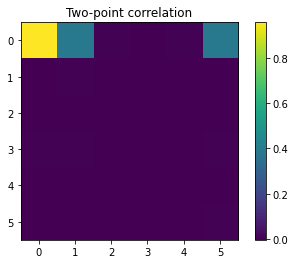

In [5]:
w = torch.Tensor(
    [
        [0, 0, 0],
        [0, 1, 0.5],
        [0, 0, 0],
    ]
)
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w)).squeeze(1)

plot.heatmap_covariance(conv_out)
plot.heatmap_correlator(conv_out)
plt.show()

### Example: Nearest positive neighbours

Now consider the kernel

$$
w = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 1/2 \\
0 & 1/2 & 0
\end{pmatrix}
$$

The variance this time is,

$$
\langle (w \star \phi)_{00} (w \star \phi)_{00} \rangle 
= \langle \phi_{00} \phi_{00} \rangle
+ \frac{1}{4} \langle \phi_{01}\phi_{01} \rangle 
+ \frac{1}{4} \langle \phi_{10}\phi_{10} \rangle
= \frac{3}{2}
$$

Now the covariance with the (0, 1) element, $(w \star \phi)_{01} = \phi_{01} + \frac{1}{2}(\phi_{02} + \phi_{11})$,

$$
\langle (w \star \phi)_{00} (w \star \phi)_{01} \rangle 
= \frac{1}{2} \langle \phi_{01} \phi_{01} \rangle
= \frac{1}{2}
$$

By similar arguments, 

$$
\langle (w \star \phi)_{00} (w \star \phi)_{10} \rangle = \langle (w \star \phi)_{00} (w \star \phi)_{L0} \rangle = \langle (w \star \phi)_{00} (w \star \phi)_{0L} \rangle = \frac{1}{2}
$$

There is one more non-trivial covariance, which is $\langle (w \star \phi)_{00} (w \star \phi)_{1L} \rangle = \langle (w \star \phi)_{00} (w \star \phi)_{L1} \rangle$.

$$
\langle (w \star \phi)_{00} (w \star \phi)_{1L} \rangle 
= \left\langle \left(\phi_{00} + \frac{1}{2} \phi_{01} + \frac{1}{2} \phi_{10}\right)
\left(\phi_{L1} + \frac{1}{2} \phi_{L2} + \frac{1}{2} \phi_{01}\right) \right\rangle
= \frac{1}{4} \langle \phi_{01} \phi_{01} \rangle
= \frac{1}{4}
$$

''

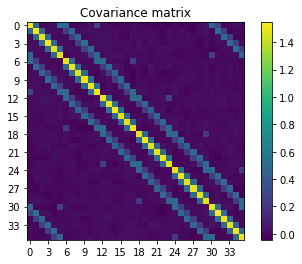

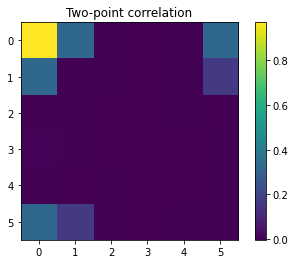

In [6]:
w = torch.Tensor(
    [
        [0, 0, 0],
        [0, 1, 0.5],
        [0, 0.5, 0],
    ]
)
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w)).squeeze(1)

plot.heatmap_covariance(conv_out)
plot.heatmap_correlator(conv_out)
plt.show()

### Example: Nearest neighbours

''

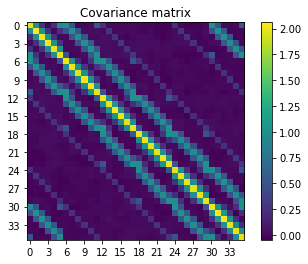

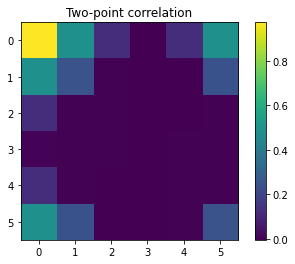

In [7]:
w = torch.Tensor(
    [
        [0, 0.5, 0],
        [0.5, 1, 0.5],
        [0, 0.5, 0],
    ]
)
conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w)).squeeze(1)

plot.heatmap_covariance(conv_out)
plot.heatmap_correlator(conv_out)
plt.show()

# Rotational equivariance

Consider a rotationally invariant kernel,

$$
w = 
\begin{pmatrix}
f & e & c & e & f \\
e & d & b & d & e \\
c & b & a & b & c \\
e & d & b & d & e \\
f & e & c & e & f \\
\end{pmatrix}
$$

If $\phi$ is also rotationally invariant, e.g. due to lattice isotropy, the result should also be rotationally invariant.



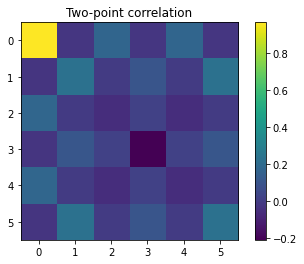

In [12]:
L = 6
prior = torch.distributions.Normal(loc=torch.zeros(L, L), scale=torch.ones(L, L))
phi = prior.sample([10000])

w = torch.zeros(5, 5)
x = torch.empty(3, 3).normal_()
w[2:, 2:] = x + x.T
w += w.flip(0)
w += w.flip(1)

assert torch.allclose(w, w.flip(0))
assert torch.allclose(w, w.flip(1))
assert torch.allclose(w, w.flip(0, 1))

conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w)).squeeze(1)

_, cov = get_covariance(conv_out)
# print(cov)

plot.heatmap_correlator(conv_out)
plt.show()

We can compose multiple cross-correlations and still preserve the rotational invariance

tensor([[ 0.042, -0.009,  0.025, -0.005,  0.025, -0.009],
        [-0.009,  0.030, -0.005,  0.015, -0.005,  0.030],
        [ 0.026, -0.005,  0.010, -0.001,  0.010, -0.005],
        [-0.005,  0.016, -0.001, -0.001, -0.001,  0.016],
        [ 0.026, -0.005,  0.010, -0.001,  0.010, -0.005],
        [-0.009,  0.030, -0.005,  0.015, -0.005,  0.030]])


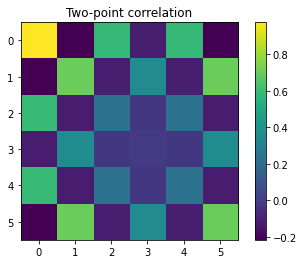

In [13]:
conv_out = phi
for _ in range(4):
    conv_out = torch.nn.functional.conv2d(*conv2d_inputs(conv_out, w)).squeeze(1)
    conv_out /= conv_out.max()

_, cov = get_covariance(conv_out.squeeze(1))
print(cov)

plot.heatmap_correlator(conv_out)
plt.show()

# Computing the density

In [20]:
def pad_and_roll_kernel(phi, w):
    """Pad and roll kernel so that we can compute the cross-correlation."""
    L1, L2 = phi.shape[-2:]
    k1, k2 = [(k - 1) // 2 for k in w.shape]

    # Pad with zeros to make it the same size as phi
    w = torch.nn.functional.pad(
        w, (0, L2 - w.shape[1], 0, L1 - w.shape[0]), mode="constant", value=0
    )

    # Roll the kernel
    w = w.roll((-k1, -k2), (0, 1))

    return w


def to_matrix_vector(w, phi):
    """Convert a kernel and 2d state to an equivalent matrix-vector form.

        w * \phi  == W . Phi

    Inputs
    ------
    w: 2-dimensional kernel
    phi: 2-dimensional state, with optional batch dimension

    Returns
    -------
    W: square matrix whose dimensions are equal to the size of a 2-d state
    Phi: vectorised state, i.e. with lattice dimensions flattened
    """
    assert phi.dim() in (2, 3)
    if phi.dim() == 2:
        phi = phi.unsqueeze(0)

    # (0, 0) element is in top left
    w = pad_and_roll_kernel(phi, w)
    assert w.dim() == 2

    W = torch.stack(
        [
            w.roll((x1, x2), dims=(0, 1)).flatten()
            for x1, x2 in itertools.product(range(w.shape[0]), range(w.shape[1]))
        ],
        dim=0,
    )
    Phi = phi.flatten(start_dim=1)

    return W, Phi

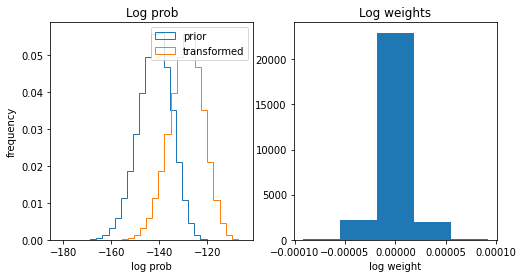

In [19]:
L = 10
prior = torch.distributions.Normal(loc=torch.zeros(L, L), scale=torch.ones(L, L))
phi = prior.sample([100000])
log_prob_prior = prior.log_prob(phi).flatten(start_dim=1).sum(dim=1)

w = torch.Tensor(
    [
        [0, 0.5, 0],
        [0.5, 1, 0.5],
        [0, 0.5, 0],
    ]
)

conv_out = torch.nn.functional.conv2d(*conv2d_inputs(phi, w)).flatten(start_dim=1)

W, Phi = to_matrix_vector(w, phi)
assert torch.allclose(conv_out[0], torch.mv(W, Phi[0]), atol=1e-6)

cov = torch.cov(conv_out.T)
# NOTE: get rid of the noise. Would need to be changed if kernel changes
cov.mul_(4).round_().div_(4)

dist = torch.distributions.MultivariateNormal(
    loc=torch.zeros(L * L), covariance_matrix=cov
)
log_prob_transformed = dist.log_prob(conv_out)

log_weight = log_prob_transformed - (log_prob_prior - torch.slogdet(W).logabsdet)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title("Log prob")
ax1.set_ylabel("frequency")
ax1.set_xlabel("log prob")
ax2.set_title("Log weights")
ax2.set_xlabel("log weight")
_ = ax1.hist(log_prob_prior, bins=25, density=True, histtype="step", label="prior")
_ = ax1.hist(
    log_prob_transformed, bins=25, density=True, histtype="step", label="transformed"
)
_ = ax2.hist(log_weight, bins=5, density=True)
ax1.legend()

# Convolutional flows
Convolutions acting on random variables result in new random variables that are weighted combinations of the previous variables.
Due to the central limit theorem, the map $\phi^t \mapsto \phi^{t+1} = w \ast \phi^t$ has a Gaussian fixed point, regardless of the distribution that $\phi^0$ was drawn from.

TODO

# Rubbish bin

acting on a $4 \times 4$ diagonal Gaussian

$$
\phi = 
\begin{pmatrix}
\phi_{00} & \phi_{01} & \phi_{02} & \phi_{03} \\
\phi_{10} & \phi_{11} & \phi_{12} & \phi_{13} \\
\phi_{20} & \phi_{21} & \phi_{22} & \phi_{23} \\
\phi_{30} & \phi_{31} & \phi_{32} & \phi_{33}
\end{pmatrix}
$$

For example,

$$
(w \star \phi)_{00} = a \phi_{00} + b(\phi_{01} + \phi_{10} + \phi_{03} + \phi_{30}) + c(\phi_{02} + \phi_{20}) + d(\phi_{11} + \phi_{13} + \phi_{31} + \phi_{33}) + e(\phi_{12} + \phi_{21} + \phi_{23} + \phi_{32}) + f \phi_{33}
$$

The diagonal elements of the covariance matrix are

$$
\langle (w \star \phi)_{ii} (w \star \phi)_{ii} \rangle 
= a^2 + 4b^2 + 2c^2 + 4d^2 + 4e^2 + f^2
$$

$$
\begin{aligned}
\langle (w \star \phi)_{00} (w \star \phi)_{01} \rangle 
&= \left\langle 
\left( a \phi_{33} + b(\phi_{03} + \phi_{30}) + c(\phi_{13} + \phi_{31}) + d\phi_{00} + e(\phi_{01} + \phi_{10}) + f\phi_{11} \right)
\left( a \phi_{30} + b(\phi_{31} + \phi_{00}) + c(\phi_{32} + \phi_{10}) + d\phi_{01} + e(\phi_{02} + \phi_{11}) + f\phi_{12} \right) 
\right\rangle \\
&= ab \langle\phi_{30}^2\rangle + cb \langle\phi_{31}^2\rangle + db\langle\phi_{00}^2\rangle + ed\langle\phi_{01}^2\rangle + ec\langle\phi_{10}\rangle + fe\langle\phi_{11}^2\rangle \\
&= ab + cb + db + ed + fe
\end{aligned}
$$

...


$$
w = 
\begin{pmatrix}
a & b & c & b \\
b & d & e & d \\
c & e & f & e \\
b & d & e & d
\end{pmatrix}
$$

In [27]:
class FreeTheoryTarget:
    def __init__(self, m_sq: int):
        self.m_sq = m_sq

    def action(self, phi: torch.Tensor):
        assert phi.dim() == 3

        action_density = torch.zeros_like(phi)
        action_density.sub_(phi.mul(phi.roll(-1, 1)))
        action_density.sub_(phi.mul(phi.roll(-1, 2)))
        action_density.add_(phi.pow(2).mul((4 + self.m_sq) / 2))

        return action_density.flatten(start_dim=1).sum(dim=1)

    def log_prob(self, phi: torch.Tensor):
        return self.action(phi).neg()


def laplacian_2d(lattice_length: int) -> torch.Tensor:
    """Creates a 2d Laplacian matrix.

    This works by taking the kronecker product of the one-dimensional
    Laplacian matrix with the identity.

    Notes
    -----
    For now, assume a square lattice. Periodic BCs are also assumed.
    """
    identity = torch.eye(lattice_length)
    lapl_1d = (
        2 * identity  # main diagonal
        - torch.diag(torch.ones(lattice_length - 1), diagonal=1)  # upper
        - torch.diag(torch.ones(lattice_length - 1), diagonal=-1)  # lower
    )
    lapl_1d[0, -1] = lapl_1d[-1, 0] = -1  # periodicity
    lapl_2d = torch.kron(lapl_1d, identity) + torch.kron(identity, lapl_1d)
    return lapl_2d

Kernel:
tensor([[0.263, 0.079, 0.044, 0.079],
        [0.079, 0.044, 0.032, 0.044],
        [0.044, 0.032, 0.025, 0.032],
        [0.079, 0.044, 0.032, 0.044]])
Covariance of output:
tensor([[0.111, 0.073, 0.059, 0.073],
        [0.073, 0.059, 0.051, 0.059],
        [0.058, 0.051, 0.046, 0.051],
        [0.073, 0.059, 0.051, 0.059]])


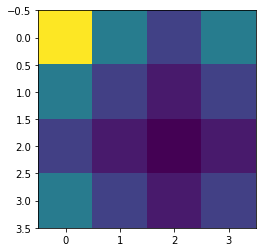

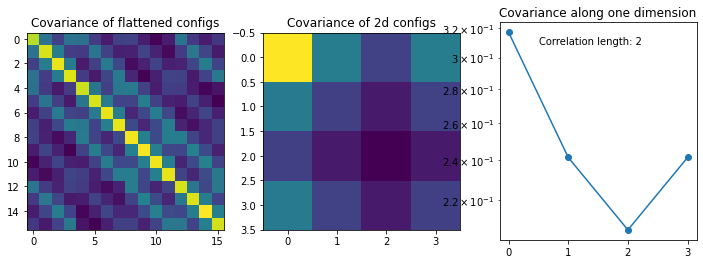

In [48]:
L = 4
M_SQ = 1
prior = torch.distributions.Normal(loc=torch.zeros(L, L), scale=torch.ones(L, L))
phi = prior.sample([10000])

prec = laplacian_2d(L) + torch.eye(L * L).mul(M_SQ)
cov_in = prec.inverse()

print("Kernel:")
print(cov_in[0].view(L, L))

mm_out = torch.mm(phi.flatten(start_dim=1), cov_in)

cov_out = torch.cov(mm_out.T)
cov_with_geometry = torch.stack(
    [
        row.view(4, 4).roll((-(i // 4), -(i % 4)), dims=(0, 1))
        for i, row in enumerate(cov_out.split(1, dim=0))
    ],
    dim=0,
).mean(dim=0)
print("Covariance of output:")
print(cov_with_geometry)
plt.imshow(cov_with_geometry)

plot_covariance(mm_out.view(-1, L, L))